# Launches Data Preprocessing Notebook 🚀👽🏰

<div class="alert alert-block alert-info">
⚠️ Download the data before running this notebook. Check the documentation.
</div>

## Data Loading 📥

In this cell, we load the launches raw dataset:

- **Launches Data:** Loaded from a JSON file.

In [30]:
import os
import json

# ============================================================
# SETUP: Define output directory relative to this script
# ============================================================
# Get the absolute path of the directory where this script is located
# In a notebook, __file__ is not defined so we use os.getcwd() as a fallback.
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

# Define the folder where raw data is stored (assumed to be "../data/raw")
RAW_DIR = os.path.join(BASE_DIR, "..", "data", "raw")

# Define the folder where processed data will be saved (assumed to be "../data/processed")
PROCESSED_DIR = os.path.join(BASE_DIR, "..", "data", "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)  # Create the folder if it doesn't exist
OUTPUT_FILE = os.path.join(PROCESSED_DIR, "spacedevs_launches_processed.json") # Build the absolute path for the output file

# Build the absolute paths for each dataset
launches_path = os.path.join(RAW_DIR, "spacedevs_launches.json")

# Load SpaceX launches data from JSON using the absolute path
with open(launches_path, "r") as f:
    launches = json.load(f)

# Extract the list of launches; ignore the "offset" for cleaning purposes.
results = launches.get("results", [])
print(f"Loaded {len(results)} launches from raw data.")

print("✅ Datasets loaded!")

Loaded 7418 launches from raw data.
✅ Datasets loaded!


## Fixing Datetime Format for Lauches Data 📆📍

In [31]:
from datetime import datetime

def convert_datetime(iso_str):
    """
    Convert an ISO datetime string like "2006-03-24T22:30:00.000Z"
    to the format "MM/DD/YYYY HH:MM".
    """
    try:
        dt = datetime.strptime(iso_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except ValueError:
        # Fallback if microseconds are not provided:
        dt = datetime.strptime(iso_str, "%Y-%m-%dT%H:%M:%SZ")
    return dt.strftime("%m/%d/%Y %H:%M")

## Selecting Only Relevant Variables From Raw Data

In [32]:
# Create list to append processed launches
processed_launches = []

for launch in results:
    processed = {}
    processed["id"] = launch.get("id")
    processed["name"] = launch.get("name")
    
    net = launch.get("net")
    processed["net"] = convert_datetime(net) if net else None
    
    # Extract status name from the nested status object, using a fallback empty dict if needed.
    status = launch.get("status") or {}
    processed["status"] = status.get("abbrev")
    
    # Extract rocket id from the nested rocket object.
    rocket = launch.get("rocket") or {}
    processed["rocket_id"] = rocket.get("id")
    
    # Extract pad details: id, name, latitude, and longitude.
    pad = launch.get("pad") or {}
    processed["pad"] = {
        "id": pad.get("id"),
        "name": pad.get("name"),
        "latitude": pad.get("latitude"),
        "longitude": pad.get("longitude"),
        "country": pad.get("country")
    }
    
    # Extract mission details: name, type, and description.
    mission = launch.get("mission") or {}
    processed["mission"] = {
        "name": mission.get("name"),
        "type": mission.get("type"),
        "description": mission.get("description")
    }
    
    # Extract launch service provider info.
    lsp = launch.get("launch_service_provider") or {}
    processed["launch_service_provider"] = {
        "id": lsp.get("id"),
        "name": lsp.get("name")
    }
    
    # Keep the URL for more info.
    processed["url"] = launch.get("url")
    
    processed_launches.append(processed)

print(f"✅ Preprocessed {len(processed_launches)} launches!")

✅ Preprocessed 7418 launches!


## Saving the Processed Lauches and Launchpads Data 💾

In [33]:
# Save the updated launches back to a JSON file (no spaces, no identation)
with open(OUTPUT_FILE, "w") as f:
    json.dump(processed_launches, f, separators=(',', ':'))

print("💾 Saved processed launches dataset!")

💾 Saved processed launches dataset!


## Making Some Preliminar Analysis on the Processed Launches 📉

In [34]:
import pandas as pd

# Create DataFrame from launches data
launches_df = pd.DataFrame(processed_launches)

# Our cleaned data has 'net' in "MM/DD/YYYY HH:MM" format.
launches_df['net'] = pd.to_datetime(launches_df['net'], format="%m/%d/%Y %H:%M", errors='coerce')

# Our dataset apparently have launches that are going to happen in the future
# We need to exclude them from our evaluation
# Start by getting today's datetime
current_datetime = datetime.today().strftime('%Y-%m-%d %H:%M:%S')

# Use loc to keep only present and past launches
launches_df = launches_df.loc[launches_df['net'] <= current_datetime]

# Show basic info about the data
print("Total launches:", len(launches_df),"\n")
print(launches_df.tail())

Total launches: 7091 

                                        id  \
7086  6632587d-9290-4cee-8a9c-ef91c61a7064   
7087  682328d3-ce10-448c-be16-c5f8f851a312   
7088  fb0df8b6-7b94-4e49-93e0-5389755fc970   
7089  f842964b-288f-4100-95d4-3b3510712f81   
7090  e4c34b02-4b70-495b-9bc9-5cd19788ff2c   

                                            name                 net   status  \
7086   Falcon 9 Block 5 | WorldView Legion 5 & 6 2025-02-04 23:13:00  Success   
7087    Soyuz 2.1v/Volga | Kosmos 2581/2582/2583 2025-02-05 03:59:00  Success   
7088      Falcon 9 Block 5 | Starlink Group 12-9 2025-02-08 18:23:00       Go   
7089  Electron | IoT 4 You and Me (Kinéis 16-20) 2025-02-08 20:43:00       Go   
7090     Falcon 9 Block 5 | Starlink Group 11-10 2025-02-10 00:03:00       Go   

      rocket_id                                                pad  \
7086       7547  {'id': 87, 'name': 'Launch Complex 39A', 'lati...   
7087       8512  {'id': 85, 'name': '43/4 (43R)', 'latitude': 6...   
708

## How Many Launches Occur Per Year and Per Month? 📆

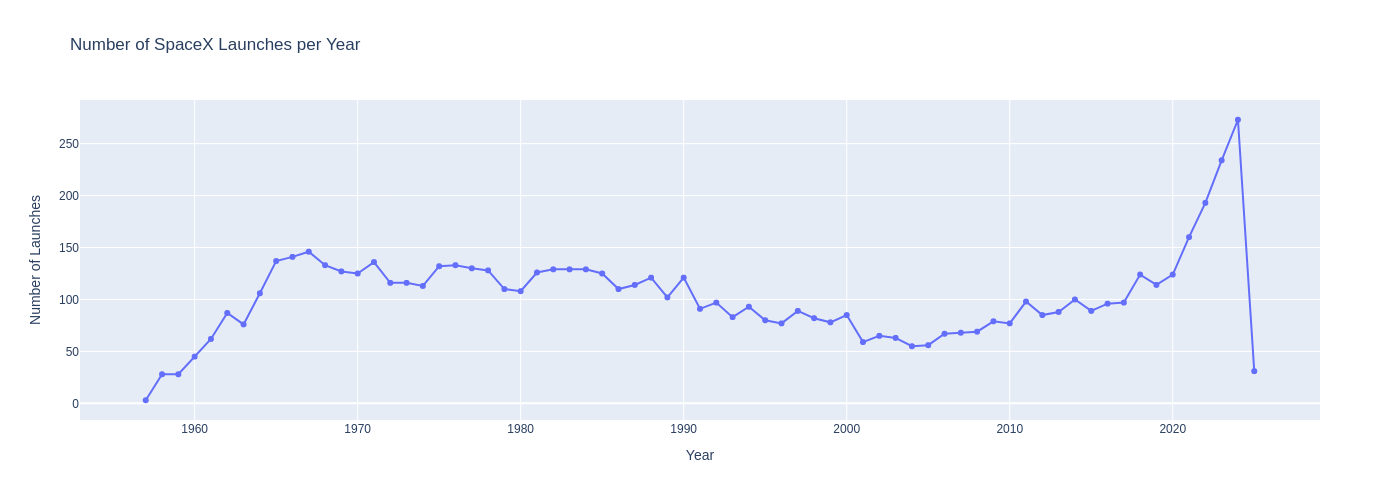

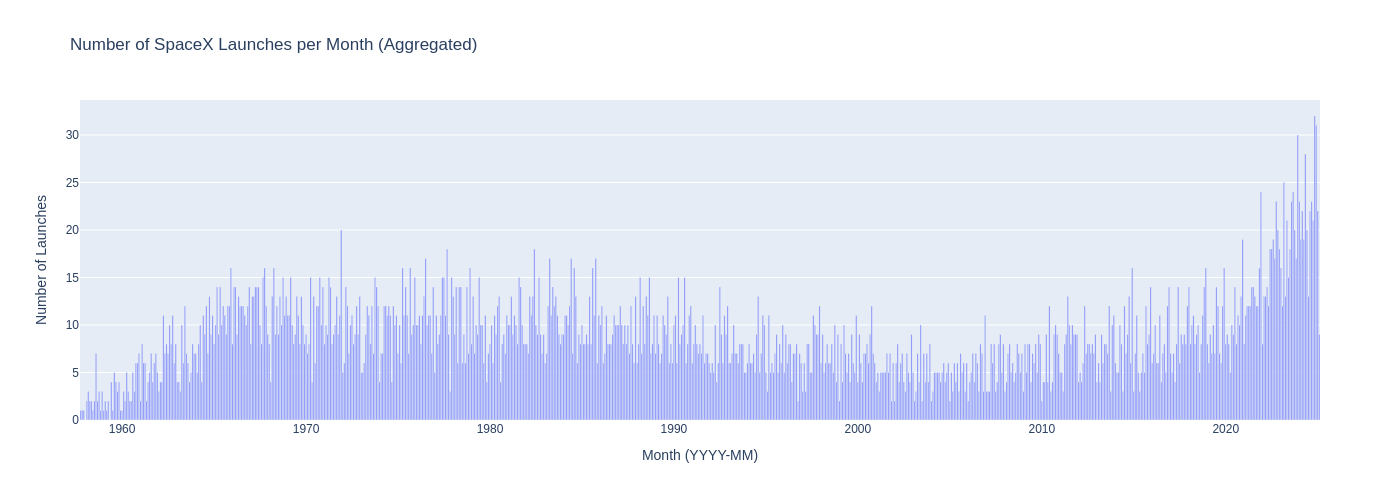

In [35]:
import plotly.express as px

# Create a column for year and month
launches_df['year'] = launches_df['net'].dt.year
launches_df['month'] = launches_df['net'].dt.to_period('M').astype(str)

# Count launches per year
launches_per_year = launches_df.groupby('year').size().reset_index(name='launch_count')
fig_year = px.line(
    launches_per_year, 
    x='year', 
    y='launch_count',
    markers=True,
    title="Number of SpaceX Launches per Year",
    labels={'year': 'Year', 'launch_count': 'Number of Launches'},
    width=1400
)

# Remove renderer="png" to have an interactive image
fig_year.show(renderer="png")

# Count launches per month (aggregated across all years)
launches_per_month = launches_df.groupby('month').size().reset_index(name='launch_count')
fig_month = px.bar(
    launches_per_month, 
    x='month', 
    y='launch_count',
    title="Number of SpaceX Launches per Month (Aggregated)",
    labels={'month': 'Month (YYYY-MM)', 'launch_count': 'Number of Launches'},
    width=1400
)

# Remove renderer="png" to have an interactive image
fig_month.show(renderer="png")

## How Many Launches Succeeded? 🔍

            status  count
0          Success   6549
1          Failure    505
2  Partial Failure     34
3               Go      3


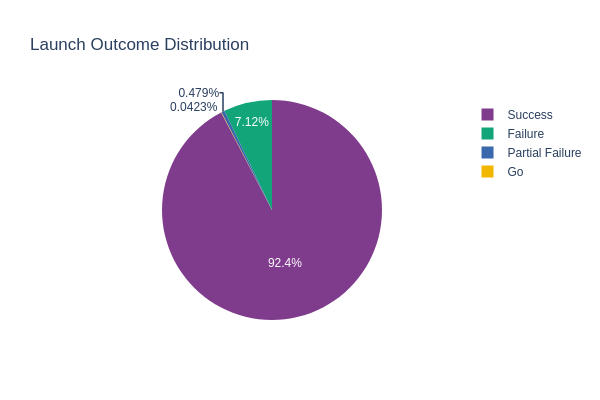

In [36]:
# Count the number of launches per status
status_counts = launches_df['status'].value_counts().reset_index()
status_counts.columns = ['status', 'count']
print(status_counts)

fig_status = px.pie(
    status_counts,
    names='status',
    values='count',
    title="Launch Outcome Distribution",
    color_discrete_sequence=px.colors.qualitative.Bold,
    width=600,
    height=400
)

# Remove renderer="png" to have an interactive image
fig_status.show(renderer="png")

## Which Launchpads Have Hosted the Most Launches? 🚀

                    pad_name  launch_count
0                        1/5           487
23                      31/6           420
32                43/4 (43R)           323
29                      41/1           310
168  Space Launch Complex 40           287


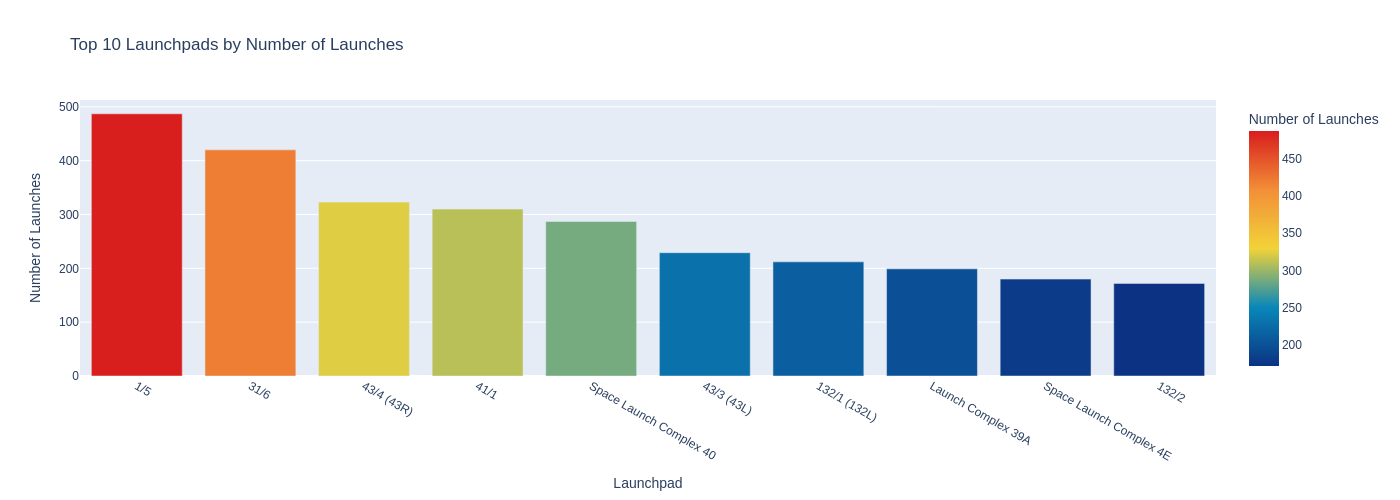

In [37]:
# Extract launchpad information from the nested "pad" dictionary.
# We create a new DataFrame with launchpad id and name.
launches_df['pad_id'] = launches_df['pad'].apply(lambda x: x.get("id") if isinstance(x, dict) else None)
launches_df['pad_name'] = launches_df['pad'].apply(lambda x: x.get("name") if isinstance(x, dict) else None)

# Count launches per launchpad
launchpad_counts = launches_df.groupby('pad_name').size().reset_index(name='launch_count')
launchpad_counts = launchpad_counts.sort_values(by='launch_count', ascending=False)
print(launchpad_counts.head())

fig_launchpads = px.bar(
    launchpad_counts.head(10),
    x='pad_name',
    y='launch_count',
    title="Top 10 Launchpads by Number of Launches",
    labels={'pad_name': 'Launchpad', 'launch_count': 'Number of Launches'},
    color='launch_count',
    color_continuous_scale='Portland',
    width=1400
)

# Remove renderer="png" to have an interactive image
fig_launchpads.show(renderer="png")

## Where Are Located the Launchpads? 🌍

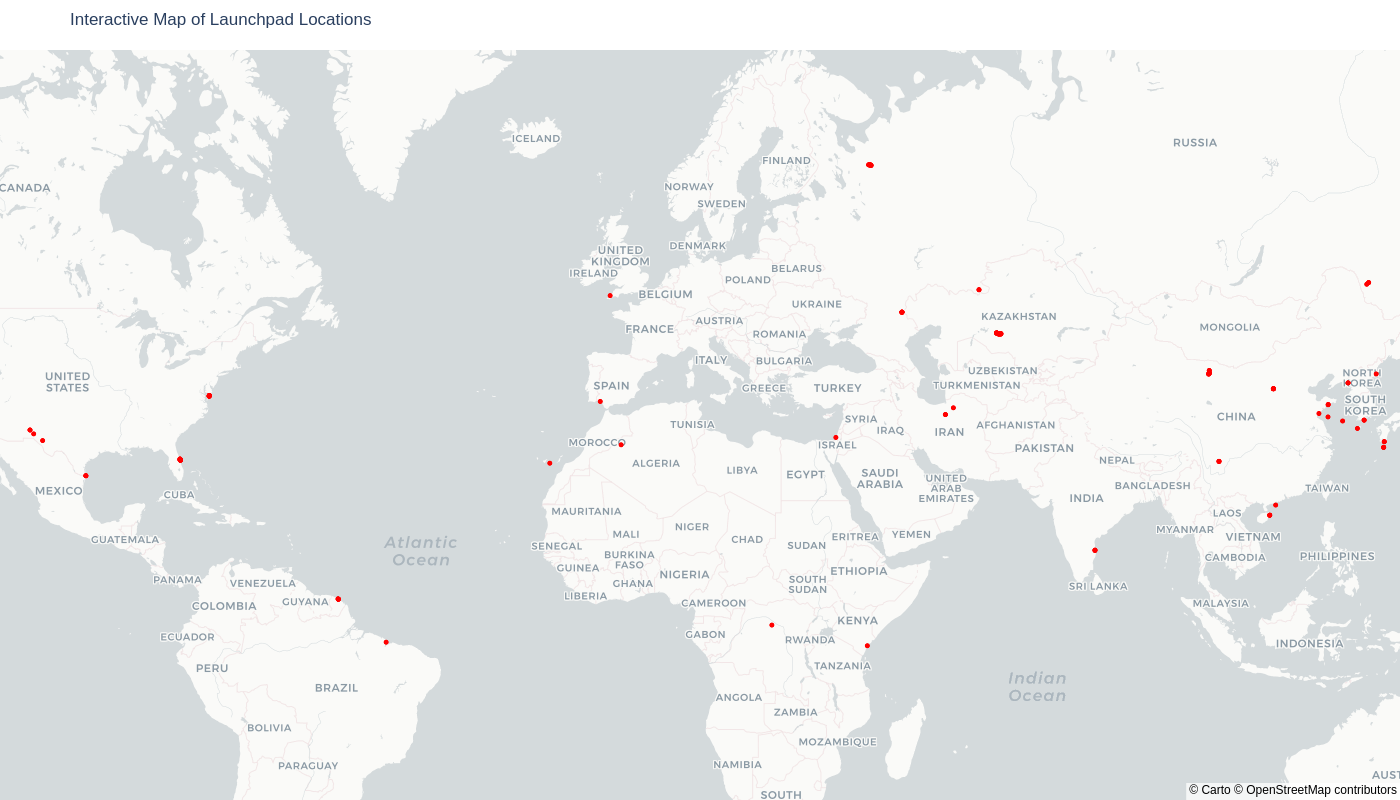

In [38]:
# Extract latitude and longitude for each launch from the nested pad dictionary.
launches_df['pad_lat'] = launches_df['pad'].apply(lambda x: x.get("latitude") if isinstance(x, dict) else None)
launches_df['pad_lon'] = launches_df['pad'].apply(lambda x: x.get("longitude") if isinstance(x, dict) else None)

# Filter out launchpads that have "landing site" in their name (case insensitive)
launchpads_map_df = launches_df[~launches_df['pad_name'].str.contains("landing site", case=False, na=False)].copy()

# Drop rows with missing coordinates
launchpads_map_df = launchpads_map_df.dropna(subset=['pad_lat', 'pad_lon']).drop_duplicates(subset=['pad_id'])

fig_map = px.scatter_mapbox(
    launchpads_map_df,
    lat="pad_lat",
    lon="pad_lon",
    hover_name="pad_name",
    hover_data=["pad_id"],
    color_discrete_sequence=["red"],
    zoom=2,
    height=800,
    width=1400,
    title="Interactive Map of Launchpad Locations"
)

fig_map.update_layout(mapbox_style="carto-positron", margin={"r":0,"t":50,"l":0,"b":0})

# Remove renderer="png" to have an interactive image
fig_map.show(renderer="png")

## How Many Launches per Country? 🚀

In [39]:
# Extract pad details: id, name, latitude, longitude, and country (if available).
def extract_pad_info(pad):
    if isinstance(pad, dict):
        # Try multiple keys for country if needed
        country = None
        if "country" in pad and isinstance(pad["country"], dict):
            country = pad["country"].get("name")
        elif "country_name" in pad:
            country = pad.get("country_name")
        return {
            "id": pad.get("id"),
            "name": pad.get("name"),
            "latitude": pad.get("latitude"),
            "longitude": pad.get("longitude"),
            "country": country
        }
    else:
        return None

# Create new columns for pad info
launches_df['pad_info'] = launches_df['pad'].apply(extract_pad_info)

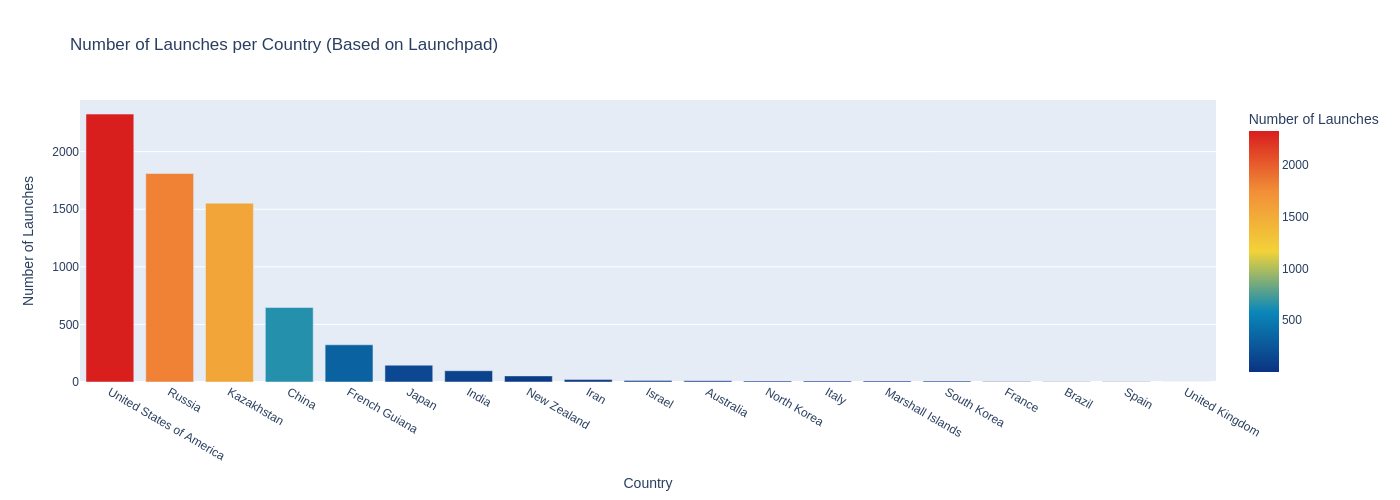

In [40]:
# Extract pad country for each launch from the nested pad dictionary.
launches_df['pad_country'] = launches_df['pad_info'].apply(lambda x: x.get("country") if isinstance(x, dict) else None)

# Group by pad country and count launches
launches_by_country = launches_df.groupby('pad_country').size().reset_index(name='launch_count')
launches_by_country = launches_by_country.dropna(subset=['pad_country'])

# Order the data descending by launch_count
launches_by_country = launches_by_country.sort_values(by='launch_count', ascending=False)

fig_country = px.bar(
    launches_by_country,
    x='pad_country',
    y='launch_count',
    title="Number of Launches per Country (Based on Launchpad)",
    labels={'pad_country': 'Country', 'launch_count': 'Number of Launches'},
    color='launch_count',
    color_continuous_scale='Portland',
    width=1400
)

# Remove renderer="png" to have an interactive image
fig_country.show(renderer="png")

## What are the Mission Types?

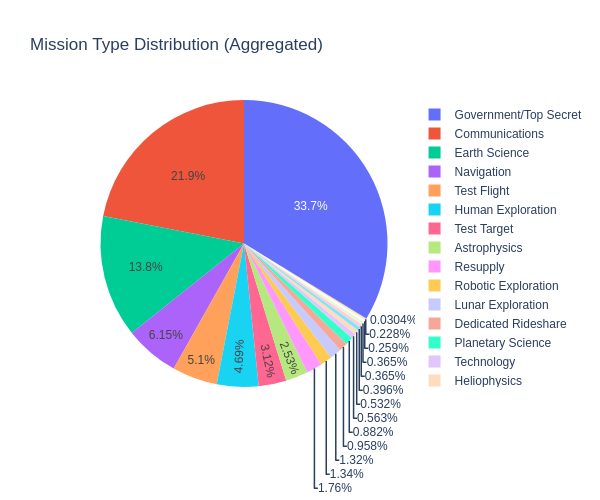


Aggregated mission type counts for pie chart:  mission_type
Government/Top Secret    2216
Communications           1441
Earth Science             906
Navigation                404
Test Flight               335
Human Exploration         308
Test Target               205
Astrophysics              166
Resupply                  116
Robotic Exploration        88
Lunar Exploration          87
Dedicated Rideshare        63
Planetary Science          58
Technology                 37
Heliophysics               35
                           26
Suborbital                 24
Materials Science          24
Biology                    17
Tourism                    15
Other                       2
Name: count, dtype: int64


In [41]:
# %% [code]
# Extract mission type from the mission dictionary
def extract_mission_type(mission):
    if isinstance(mission, dict):
        return mission.get("type")
    return None

launches_df['mission_type'] = launches_df['mission'].apply(extract_mission_type)

# Count frequencies
mission_counts = launches_df['mission_type'].value_counts(dropna=True)

# Define threshold: e.g., if a mission type appears less than 10 times, aggregate as "Other"
threshold = 10
aggregated_mission_type = mission_counts.copy()
aggregated_mission_type[aggregated_mission_type < threshold] = 0
other_count = mission_counts[mission_counts < threshold].sum()

# Build a new series for plotting
plot_data = mission_counts[mission_counts >= threshold].copy()
if other_count > 0:
    plot_data["Other"] = other_count


fig_pie = px.pie(
    names=plot_data.index,
    values=plot_data.values,
    title="Mission Type Distribution (Aggregated)",
    width=600,
    height=500
)

# Remove renderer="png" to have an interactive image
fig_pie.show(renderer="png")

print("\nAggregated mission type counts for pie chart: ", plot_data)

## What are the Top Terms Used in the Launches' Descriptions? 💬

In [42]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

# Extract all mission descriptions that are not null.
mission_descriptions = launches_df['mission'].apply(lambda m: m.get("description") if isinstance(m, dict) else None)
mission_descriptions = mission_descriptions.dropna()

# Clean the text: lowercase, remove punctuation, etc.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

cleaned_descriptions = mission_descriptions.apply(clean_text)

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')
                 
# Use TF-IDF to find important terms.
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = vectorizer.fit_transform(cleaned_descriptions)
feature_names = vectorizer.get_feature_names_out()

# Sum the TF-IDF score for each term
tfidf_sum = tfidf_matrix.sum(axis=0)
tfidf_scores = np.array(tfidf_sum).flatten()
terms_scores = list(zip(feature_names, tfidf_scores))
# Sort terms by score descending
terms_scores.sort(key=lambda x: x[1], reverse=True)

# Get top 20 terms
top_terms = terms_scores[:20]
print("Top 20 terms in mission descriptions:")
for term, score in top_terms:
    print(f"{term}: {score:.4f}")

# Use word frequency (Counter) for a simpler approach
all_words = " ".join(cleaned_descriptions.tolist()).split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)
print("\nTop 20 frequent words in mission descriptions:")
for word, count in top_words:
    print(f"{word}: {count}")

Top 20 terms in mission descriptions:
satellite: 602.2840
reconnaissance: 433.7492
filmreturn: 388.4353
satellites: 301.0256
communications: 300.0595
military: 199.0615
geostationary: 192.6106
zenit: 176.7543
system: 167.3782
navigation: 143.2558
space: 141.7997
optical: 133.3265
series: 119.0965
early: 117.0888
orbit: 116.6245
communication: 116.3991
earth: 112.0996
first: 108.0686
elint: 106.9695

Top 20 frequent words in mission descriptions:
the: 10386
satellite: 4761
of: 4740
and: 4547
a: 3461
to: 3369
for: 2462
satellites: 2355
was: 2174
is: 1852
in: 1814
space: 1419
reconnaissance: 1353
by: 1314
communications: 1231
on: 1225
system: 1153
mission: 1112
with: 1062
orbit: 911


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lferr10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lferr10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## What are the Underlying Themes Observed in the Mission Descriptions? 🌌

In [43]:
# Define API directory
API_KEY_DIR = os.path.join(BASE_DIR, "..", "google_api_key.txt")

# Load Google Gemini API
with open(API_KEY_DIR, 'r') as f:
    api_key = f.read().replace('\n','')

In [45]:
from google import genai

# Extract mission descriptions from the launches DataFrame.
# We assume that 'mission' is a dictionary containing a "description" key.
mission_descriptions = launches_df['mission'].apply(lambda m: m.get("description") if isinstance(m, dict) else None)
mission_descriptions = mission_descriptions.dropna()

# Combine all mission descriptions into one large text block.
all_descriptions = " ".join(mission_descriptions.tolist())
print("Total length (in characters):", len(all_descriptions))

# Set the prompt that will be given to the LLM.
prompt = f"""
Summarize the following text in clear and concise language. The text describes multiple rocket launch missions.
1. Focus on extracting the primary mission objectives, key accomplishments, and notable challenges mentioned.
2. Your summary should capture the overall essence of the missions, highlighting the most important details.
3. Identify the underlying themes observed in mission descriptions from the 1950s to the present.
The main question to answer is: "What patterns and trends have emerged in rocket missions over time?"
Text: {all_descriptions}
"""

# Set your api-key.
client = genai.Client(api_key=api_key)

# Instantiate the LLM; you can adjust temperature and model as needed.
response = client.models.generate_content(
    model="gemini-2.0-flash", contents=prompt
)

Total length (in characters): 1096015


In [46]:
from IPython.display import Markdown as md

md(response.text)

## Summary of Rocket Mission Trends (1950s - Present)

**Primary Mission Objectives and Key Accomplishments:**

*   **Early Focus (1950s-1960s):**  Initial missions prioritized demonstrating basic launch capabilities, orbiting artificial satellites (including the first satellites with animals and solar power), exploring the Van Allen Radiation Belt, developing communications and weather satellites, and achieving lunar impacts and flybys. Crewed missions began with suborbital and then orbital flights, focusing on testing spacecraft and human endurance.
*   **Lunar and Planetary Exploration (1960s-1970s):** Significant effort was directed toward lunar orbiters, landers, and photographic missions, culminating in crewed lunar landings.  Venus and Mars flyby and lander probes were also prominent.
*   **Earth Observation and Military Applications (1960s-1980s):**  A parallel track focused on Earth observation (weather, geodesy, environmental studies) and reconnaissance (imaging satellites under programs like CORONA). Early warning systems for missile detection were also developed. Communication satellite technology became increasingly sophisticated, with the development of geosynchronous and multi-channel satellites.
*   **Space Stations and Shuttle Era (1970s-2010s):** The establishment of long-duration space stations like Salyut and Mir allowed for extended research and development of space-based assembly and docking techniques (Gemini Program, Apollo-Soyuz). Space Shuttle missions emphasized both scientific research (Spacelab) and deployment/retrieval of satellites.
*   **Modern Era (2000s-Present):**  A surge in commercial space activities with communications satellites, Internet constellations, and Earth observation satellites. An increase of public-private partnerships (such as partnerships with NASA) for both low Earth orbit operations and deep space missions. Return to planetary missions such as probes to Mercury, Jupiter, and minor planets, and the growing focus on exoplanets.

**Notable Challenges:**

*   Launch vehicle failures were common in the early decades, leading to lost payloads and mission delays.
*   Re-entry challenges, particularly capsule recovery, proved difficult.
*   In-space system failures, including power, communication, and guidance malfunctions, impacted mission success.
*   Spacewalks were hazardous and often encountered unforeseen difficulties (e.g., spacesuit problems).

**Underlying Themes and Emerging Trends:**

*   **From Test to Task:** Early missions were primarily for testing basic feasibility and technology. Over time, emphasis shifted to specialized scientific, commercial, and military applications.
*   **Increased Complexity:** Satellites and missions evolved from simple devices with single objectives to sophisticated platforms with multiple instruments and complex operational goals.
*   **Miniaturization and Constellations:** There has been a focus on smaller, more cost-effective satellites, and their deployment in large constellations for broader coverage and redundancy (e.g., Starlink, Globalstar).
*   **Growing Commercialization:** Space activities are no longer solely the domain of governments. Private companies are playing an increasingly important role in launch services, communications, Earth observation, and even human spaceflight (commercial crew program).
*   **International Collaboration:** Space exploration and research have increasingly involved collaborations between multiple countries, sharing expertise and resources.
*   **Focus on Sustainability:** There is growing concern about space debris and a resulting increase of attempts to develop means of deorbiting spacecraft after the end of their useful life.

In conclusion, rocket missions have transitioned from basic demonstrations of spaceflight to increasingly complex and specialized endeavors driven by scientific curiosity, commercial opportunities, and national security interests. While technological challenges persist, the trajectory points toward a future of more frequent, diverse, and sustainable activities in space, both near Earth and beyond.
